In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

# Load data from CSV files
x_data_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"
y_data_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

x_data = pd.read_csv(x_data_file)
y_data = pd.read_csv(y_data_file)

# Split the data into X (input features) and Y (target - c-parameters)
X_data = x_data.values.astype(np.float32)
Y_data = y_data.values.astype(np.float32)

# Create Min-Max scalers for input data and target values
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.2, random_state=42)

# Define a custom neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # New hidden layer
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)     # New activation function
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Create a Skorch wrapper for the neural network with Early Stopping
net = NeuralNetRegressor(
    module=NeuralNetwork,
    module__input_size=X_data.shape[1],
    module__hidden_size1=256,
    module__hidden_size2=256,
    module__hidden_size3=128,   # New hidden layer size
    module__output_size=Y_data.shape[1],
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.0005,
    max_epochs=3000,
    callbacks=[EarlyStopping(patience=20)],
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Use GPU if available
)

# Train the model
history = net.fit(X_train, y_train)

# Extract the training and validation losses from the history
train_losses = history.history[:, 'train_loss']
valid_losses = history.history[:, 'valid_loss']

# Evaluate the model on the test set
y_pred = net.predict(X_test)

# Inverse scale the predictions to the original range
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

# Save the trained model
torch.save(net.module_.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
net.module_.load_state_dict(torch.load('trained_model.pth'))
net.module_.eval()

# Example prediction for a single input 
X_example = X_test[0]
X_example_tensor = torch.tensor(X_example, dtype=torch.float32)
with torch.no_grad():
    prediction = net.module_(X_example_tensor.unsqueeze(0))  # Unsqueeze to add batch dimension

# Inverse scale the prediction to the original range
prediction_original = target_scaler.inverse_transform(prediction.numpy())

# Print the predicted 'c-parameters'
predicted_parameters = prediction_original[0].tolist()
print(f'Predicted c-parameters:')
print(prediction_original[0].tolist())

# val error usually around 0.04
# r-squared value usually around 0.5 


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1087        0.0791  0.2306
      2        0.0778        0.0780  0.1897
      3        0.0771        0.0774  0.1733
      4        0.0767        0.0770  0.2034
      5        0.0762        0.0768  0.1720
      6        0.0758        0.0765  0.1668
      7        0.0754        0.0757  0.1793
      8        0.0749        0.0751  0.1710
      9        0.0743        0.0744  0.1691
     10        0.0737        0.0738  0.1708
     11        0.0732        0.0732  0.1907
     12        0.0729        0.0729  0.1891
     13        0.0726        0.0727  0.1628
     14        0.0724        0.0724  0.1806
     15        0.0722        0.0723  0.1796
     16        0.0720        0.0721  0.1631
     17        0.0718        0.0719  0.1624
     18        0.0717        0.0718  0.1607
     19        0.0715        0.0717  0.1752
     20        0.0714        0.0715  0.1630
     21        0.0713        0.0

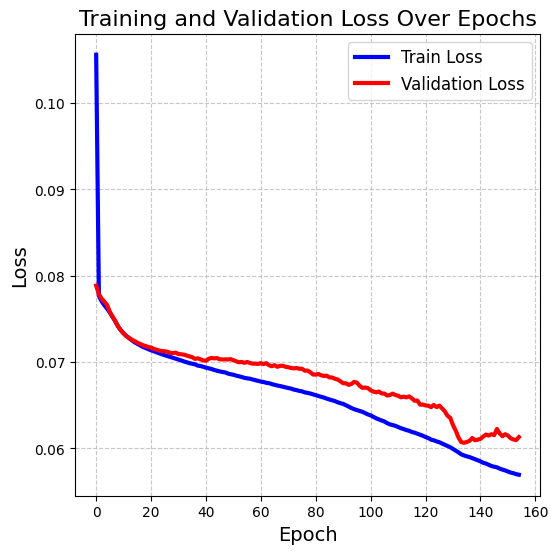

In [3]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss', linestyle='-', color='blue', linewidth=3)
plt.plot(valid_losses, label='Validation Loss', linestyle='-', color='red', linewidth=3)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

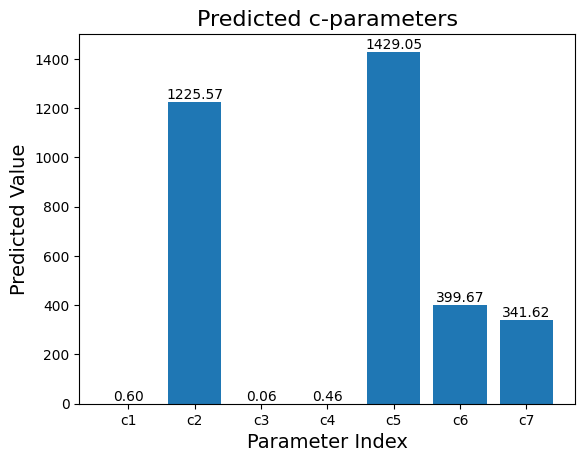

In [7]:
# Plot the predicted c-parameters in a bar chart
parameter_labels = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

plt.bar(parameter_labels, predicted_parameters)
plt.xlabel('Parameter Index', fontsize=14) 
plt.ylabel('Predicted Value', fontsize=14)  
plt.title('Predicted c-parameters', fontsize=16)  

# Add text labels for each bar
for i, value in enumerate(predicted_parameters):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [8]:
# Define the desired ranges for the second and sixth variables
fourth_variable_range = [0.04, 0.17]
sixth_variable_range = [700, 1500]

# Create a copy of the original predicted c-parameters
prediction_adjusted = np.copy(prediction_original)

# Ensure the second variable is within the desired range
prediction_adjusted[0, 3] = np.clip(prediction_adjusted[0, 3], *fourth_variable_range)

# Ensure the sixth variable is within the desired range
prediction_adjusted[0, 5] = np.clip(prediction_adjusted[0, 5], *sixth_variable_range)

# Print the predicted 'c-parameters' with adjusted values
print(f'Predicted c-parameters with adjusted values:')
print(prediction_adjusted[0].tolist()) 

Predicted c-parameters with adjusted values:
[0.6012121438980103, 1225.57421875, 0.05526614934206009, 0.17000000178813934, 1429.052490234375, 700.0, 341.6221923828125]


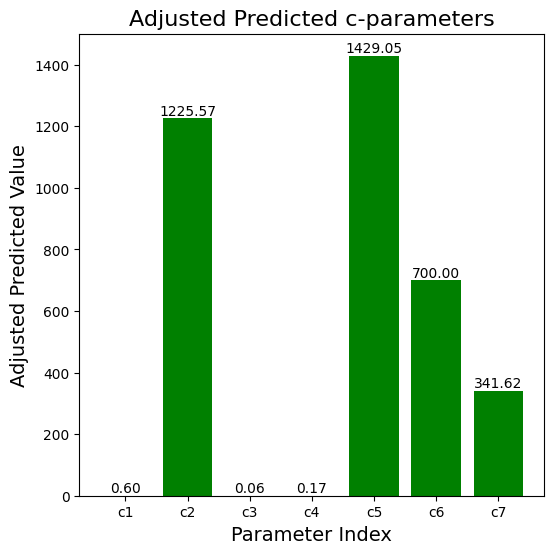

In [9]:
# Plot the adjusted predicted c-parameters in a bar chart
parameter_labels = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

plt.figure(figsize=(6, 6))
plt.bar(parameter_labels, prediction_adjusted[0], color='green')
plt.xlabel('Parameter Index', fontsize=14)
plt.ylabel('Adjusted Predicted Value', fontsize=14)
plt.title('Adjusted Predicted c-parameters', fontsize=16)

# Add text labels for each bar  (predicted values)
for i, value in enumerate(prediction_adjusted[0]):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [7]:
np.save('loss_values_25C.npy', {'train': train_losses, 'valid': valid_losses})
